# Tutorial 1: Pairwise invasibility plots
[Notebook](./dyad01_student.ipynb)

[Correction](./dyad01c.ipynb)

The objective of this tutorial is to teach the student about practical
adaptive dynamics.

*Concepts*: Assumptions of adaptive dynamics, invasion fitness, Pairwise
invasibility plot.


In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial

%matplotlib inline

## Biological problem

*In this section the T.A. presents a (hopefully) interesting biological problem, and ask the students what method could be used to solve it (spoiler: here it's adaptive dynamics). The class then come back on the important results about this method learnt from the course.*

It has been observed that animals seems to present morphological
characteristics that seems adapted to their foraging
technique. Observing fishes we see deep body shape in the littoral
zone and when preying on sedentary benthic prey, predicted to be
adaptive since it allows a higher precision in maneuverability (Webb
1984; Domenici 2003). In contrast, a body shape, allowing rapid accelaration is predicted
to be beneficial when foraging on planktonic prey (Webb 1984; Domenici
2003).  

![fish shape plane](./figures/fish_shape.png "Functional Morphology Plane (from Webb 1984)")

*Figure: Functional Morphology Plane (from Webb 1984)* Fishes in the corner are specialized for one swimming function.

What are the evolutionary consequence of such a partition of
ressource ? Will we see pure strategies evolve (only hunting benthic
prey or foraging plankton) or mixed ? Under which conditions ? Could
it lead to speciation ?

What will we use to solve this ? *Adaptive dynamics* ! (of course this
is the title of the tutorial). 

Reminder of the main hypothesis of adaptive dynamics (Geritz 1992):

We separate ecological and evolutionary timescale by considering that
mutations are rare enough so they appear in a monomorphic resident
mutation. From there they can either invade or disappear. We are just
interested in their ability to invade (measured by invasion
fitness, i.e. the exponential growth rate of a rare mutant). 

Two important assumptions:
- The resident is at ecological equilibrium. 
- The mutant is at low initial density. 

## Modeling the problem

*In this section the T.A. build the model on the blackboard
interactively with the students. The order in which the assumptions are
presented here is indicative only but present a logical progression that
can be useful to direct the discussion.*

In [1]:
## Population dynamics

Let us start by modeling the population dynamics.
The model detailed below is taken from [Claessen, 2007](http://www.evolutionary-ecology.com/issues/v09n01/ffar2073.pdf).
Here is the list of
assumptions...

-   There is a consumer $N$, and two ressources ($F_1$ and $F_2$)
    occuring in two habitats.
-   Population are unstructered, asexual, big enough to be modeled in
    $\mathbb R \to \mathbb{R}^3$, $t \mapsto (N(t), F_1(t), F_2(t))$
    (continuous time, continuous population, no
    explicit spacialization).
-   Ressource $1$ (resp $2$) follow a Chemostat dynamics with dilution
    rate $\delta_1$ (resp. $\delta_2$) and carrying capacity
    $K_1$ (resp. $K_2$). It has been argued (Persson 1998) that it was a
    realistic model of resources if (1) the resource has a physical
    refuge, (2) the resource has adult class size that are too small to
    be eaten (invulnerable) and then grow into vulnerable class size.
    (Here, doing a rough sketch of $\frac{dN}{dt} = f(N)$ can give a
    good idea of the qualitative differences between this and the logistic model you are probably more used to).
-   Consumers have a per capita birth rate $\beta$ and per capita death
    $\mu$ rate.

We get to:

\begin{equation*}
\begin{cases}
\frac{dF_1}{dt} = \delta_1 (K_1 - F_1(t))  & \text{Density of prey in env. 1} \\
\frac{dF_2}{dt} = \delta_2 (K_2 - F_2(t))  & \text{Density of prey in env. 2} \\ 
\frac{dN}{dt}  =  (\beta - \mu) N(t) & \text{Density of fish}
\end{cases}
\end{equation*}

## Predator-prey interactions

Let us walk through the hypothesis behind the interactions...

-   Spacialization is implicit in the interaction terms. No direct
    interaction between $F_1$ and $F_2$. Consumer have a heritable trait
    (denoted by $u$) which measure the specialisation for foraging $F_1$ (actually the lifespan fraction spent in environment 1).
-   Holling Functional response of type 1 (per capita consumption is
    linear with the prey density). "$ \propto F_1(t)N(t)$"
-   The value of the consumption rate is given by a search-succes rate
    in a given environment multiplied by the time spent in the
    environment: $u A_1$ and $(1-u)A_2$.
-   The search-success rate (prey cleared per unit of time spent foraging) is assumed to be (linearily) dependent on the time spent foraging. The more time spent in environment 1 leads to higher efficiency in capture of prey 1 : $u \mapsto A_1(u) = a_1+b_1u$. Foraging efficiency in environment 2 is assumed constant (Andersson 2003) : $A_2: u \mapsto A_2(u) = a_2$
-   The consumer per capita birth rate is proportional to the
    consumption rate.

SyntaxError: invalid syntax (<ipython-input-1-18c1be57da4d>, line 3)

The full model is: 
\begin{equation*}
\begin{cases}
\frac{dF_1}{dt} = \delta_1 (K_1 - F_1(t)) - F_1(t)N(t)uA_1(u)  & \text{Density of prey in env. 1} \\
\frac{dF_2}{dt} = \delta_2 (K_2 - F_2(t)) - F_2(t)N(t)(1-u)A_2(u) & \text{Density of prey in env. 2} \\ 
\frac{dN}{dt}  =  (\beta(u) - \mu) N(t) & \text{Density of fish}
\end{cases}
\end{equation*}

\begin{equation}
\beta(u) = 
\underbrace{F_1(t)}_{\text{(prey density)}}
\underbrace{A_1(u)}_{\text{(search rate)}}
\underbrace{u}_{\text{(time spent)}} + 
\underbrace{F_2(t)}_{\text{(prey density)}}
\underbrace{A_2(u)}_{\text{(search rate)}}
\underbrace{(1-u)}_{\text{(time spent)}}
\end{equation}

In [7]:
# Here are three interesting sets of parameters to explore. 
p_common = { "b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1,}  # Values common for the three sets
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}           # Neutral set
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}            # Strong efficiency in environment 2
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}             # Strong efficiency in environment 1

p_neutral

{'a1': 1,
 'b1': 0,
 'a2': 1,
 'b2': 0,
 'd1': 1,
 'd2': 1,
 'K1': 1,
 'K2': 1,
 'mu': 0.1}

## Adaptive dynamics framework

Now we want to apply our Adaptive dynamics method on the heritable trait
$u$. Remember that we need a rare mutant in a stable monomorphic
resident population.

We start by adding an equation to the system to add a mutant type. We
denote $r$ the resident trait and $m$ the mutant trait.

\begin{align}
\begin{cases}
\frac{dN_r}{dt} &= (\beta(r) - \mu) N_r(t)\\
\frac{dN_m}{dt} &= (\beta(m) - \mu) N_m(t)\\
\frac{dF_1}{dt} &= \delta_1 (K_1 - F_1(t)) - F_1(t)[ N_r(t)rA_1(r) + N_m(t)mA_1(m) ]\\
\frac{dF_2}{dt} &= \delta_2 (K_1 - F_2(t)) - F_2(t)[ N_r(t)(1-r)A_2(r) + N_m(t)(1-m)A_2(m) ]
\end{cases}
\end{align}

### Hypothesis of the adaptive dynamics (*Geritz 1998*)
- The resident is at equilibrium ($N_r = N_r^*$)
- The mutant population is small ($N_m << N_r$)
On top of these fundamental hypothesis, we assume here that the dynamics of the prey is faster than the predator's (Quasi-Steady-State, QSS), yielding:

\begin{align*}
\frac{dF_1}{dt} = \frac{dF_2}{dt} =& 0 \\ 
\Leftrightarrow& \begin{cases}
F_1^*(N_r, N_m) = \frac{\delta_1 K_1}{\delta_1 + N_r(t)rA_1(r) + N_m(t)mA_1(m)} & = \frac{\delta_1 K_1}{\delta_1 + N_r^*rA_1(r)}\\
F_2^*(N_r, N_m) = \frac{\delta_2 K_2}{\delta_2 + N_r(t)(1-r)A_2(r) + N_m(t)(1-m)A_2(m)} & = \frac{\delta_2 K_2}{\delta_2 + N_r^*(1-r)A_2(r)}\\
\end{cases}
\end{align*}

The system becomes:

\begin{align}
\begin{cases}
\frac{dN_r}{dt} &= [\beta(r, N_r(t), N_m(t)) - \mu] N_r(t)\\
\frac{dN_m}{dt} &= [\beta(m, N_r(t), N_m(t)) - \mu] N_m(t)\\
\end{cases}
\end{align}

Finding $N_r^*$ is not trivial, we'll do it numerically. Nevertheless we
can have a ballpark estimation by considering that
$\delta_1<< A_1(r)N^*$ and $\delta_1<< A_2(r)N^*$:

\begin{align*}
\beta(r, N_r(t), N_m(t)) - \mu &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*+\delta_1} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*+\delta_2} - \mu &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*}  &\approx \mu\\
\frac{\delta_1 K_1 + \delta_2 K_2}{N^*} &\approx  \mu\\\
\frac{\delta_1 K_1 + \delta_2 K_2}{\mu}  &\approx  N^*
\end{align*}

Our goal is to compute the invasion growth rate of a mutant (with trait
$m$) in an environment set by a resident (with trait value $r$). We
denote this quantity $s_r(m)$.

### Invasion fitness of the mutant

The invasion fitness $s_r(m)$ is given by:

\begin{align*}
s_r(m) =& \beta(m, N^*, 0) - \mu \\
=& F_1(N^*, 0)mA_1(m) + F_2(N^*, 0)(1-m)A_2(1-m)\\
\end{align*}

Note that $s_r(r)=0$ this is an important feature of adaptive dynamics
and checking this is a good test to do when you are trying to apply it.


In [ ]:
Numerical Pairwise invasibility plot
=============================

We want to plot the subset of $[0,1]^2$ where:

\begin{equation}
s_r(m) > 0 \;\; \text{for} \;\; m,r \in [0,1]^2
\end{equation}

You will need the following functions: 
[`scipy.optimize.fsolve`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html#scipy-optimize-fsolve),  Use the doc to
check what they are doing.

Here is a function to get you started.


In [10]:
def A(u, a, b):
    """Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate."""
    return(a + b * u)
help(A)

Help on function A in module __main__:

A(u, a, b)
    Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate.



**Exercise** Complete the following functions:

In [65]:
def n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    

def invasion_fitness(m, r, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Invasion fitness of a rare mutant type with trait m in a resident population
    with trait r"""

### Correction

In [20]:
def F1_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return( (d*K)/(A(u1, a, b)*u1*N1 + A(u2, a, b)*u2*N2 + d) )

def F2_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 2."""
    return (d*K)/(A(u1, a, b)*(1-u1)*N1 + A(u2, a, b)*(1-u2)*N2 + d)
                 
def beta(u, F1, F2, a1, b1, a2, b2):
    """Birth rate of a predator with trait u"""
    return (  F1 * A(u, a1, b1) * u 
            + F2 * A(u, a2, b2) * (1-u)) 
            
def growth_rate(N1, N2, u1, u2, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Per capita growth rate of predator species N1 when the prey is at QSS"""
    F1 = F1_QSS(d1, K1, a1, b1, u1, N1, u2, N2)
    F2 = F2_QSS(d2, K2, a2, b2, u1, N1, u2, N2)
    return beta(u1, F1, F2, a1, b1, a2, b2) - mu

def n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    # Rough estimate used to initialise the optimisation algorithm.
    estimate = (d1*K1+d2*K2)/mu
    
    # We fix the value of the other parameters before solving for N1.
    resident_growth_rate = partial(growth_rate,
                                   u1 = r,
                                   N2=0, u2=0,
                                   a1=a1, a2=a2, 
                                   b1=b1, b2=b2, 
                                   d1=d1, d2=d2,
                                   K1=K1, K2=K2, 
                                   mu=mu)
    return scipy.optimize.fsolve(resident_growth_rate,x0=estimate)
    
def invasion_fitness(m, r, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Invasion fitness of a rare mutant type with trait m in a resident population
    with trait r"""
    
    # Conpute the ecological equilibrium of the resident.
    Nstar = n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu)
    
    # Invasion fitness is the growth rate of a rare mutant (N=0, u=m)
    # in a resident population at equilibrium (N=Nstar, u=r)
    return growth_rate(N1=0, N2=Nstar, u1=m, u2=r, 
                       a1=a1, a2=a2, b1=b1, b2=b2, K1=K1, 
                       K2=K2, d1=d1, d2=d2, mu=mu)

Here are some functions to display the pairwise invasibility plot. Re-writing them on your own is a good exercise.  

They make use of: 
- [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace), 
- [`numpy.meshgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html#numpy.meshgrid), 
- [`matplotlib.pyplot.contourf`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contourf.html).
- [`numpy.frompyfunc`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.frompyfunc.html#numpy.frompyfunc)

In [6]:
def compute_pip(steps, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Return 3 matrices of size step X step:
    R: Resident population trait (constant on each column, go from 0 to 1 in the first and last column).
    M: Mutant population trait (constant on each line, go from 0 to 1 between the first and last line)
    PIP: Corresponding invasion fitness."""
    
    # Fill the R, M matrices with evenly spaced values in [0,1]. 
    R,M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))
    
    # Python tip: An efficient way to compute a multiple variable function over a domain
    # is to convert it to a "broadcastable function" that can be applied to multiple values at 
    # once. Here I do it with np.frompyfunc.
    # https://docs.scipy.org/doc/numpy/reference/ufuncs.html?highlight=ufunc for more info.
    #
    # An alternative is to loop over all values in my input matrices 
    # M and R and fill the PIP matrix one element at a time.
    s = partial(invasion_fitness, a1=a1, a2=a2,
                                  b1=b1, b2=b2,
                                  d1=d1, d2=d2,
                                  K1=K1, K2=K2,
                                  mu=mu)
    s = np.frompyfunc(s, 2, 1)
    PIP = s(M, R)
    return R, M, PIP

def display_pip(PIP, R, M, ax=None):
    """Use matplotlib to display the PIP"""
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    m = ax.contourf(R, M, PIP, 
                levels=[PIP.min(),0,PIP.max()],
                colors=['w','k'])
    ax.set(title='Pairwise invasibility plot', 
       ylabel='Mutant trait m',
       xlabel='resident trait r')

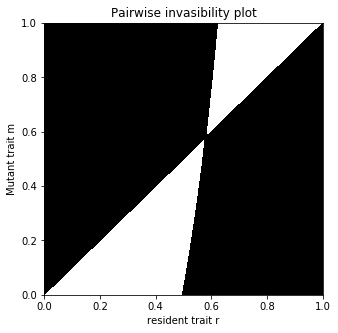

In [8]:
R, M, PIP = compute_pip(100,**p_strong)
display_pip(PIP, R, M)
plt.show()

How to read a pip
-----------------

Try to draw the pip for the three example parameter sets. 

What do you conclude for the stability of the evolutionary strategy in
each case ?

*Here, let the class discuss for a while, while drawing the four cases (Convergence stable, Evolutionary Stable) on the board. *

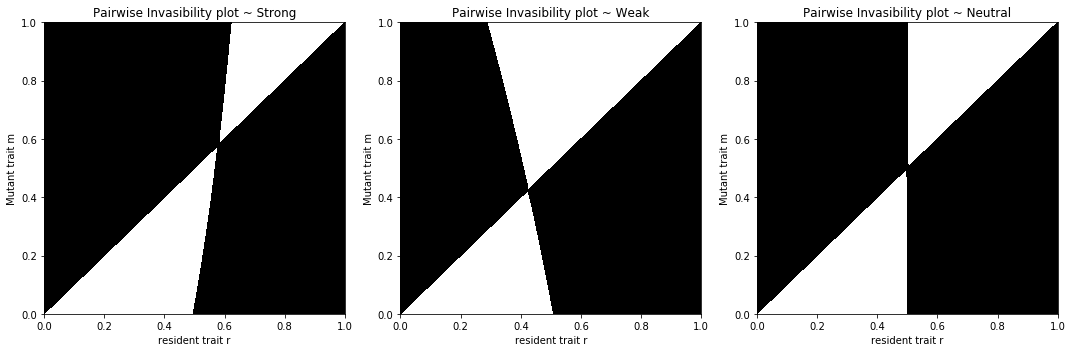

In [9]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

for i,(name,p) in enumerate((['Strong',p_strong],['Weak',p_weak],['Neutral',p_neutral])):
    r, m, pip = compute_pip(100,**p)
    display_pip(pip,r,m,ax[i])
    ax[i].set(title="Pairwise Invasibility plot ~ {}".format(name))
    
plt.tight_layout()
plt.savefig('pip.pdf',bbox_inches='tight')
plt.show()


- Convergence stability: Mutants with a higher (resp lower) value -i.e. the ones over (resp.
    under) the diagonal- can invade the resident that have a
    lower (resp. higher) value than the singular strategy (on the
    left (resp. right) of the singular point). *There is a path to get
    there*. **Look at the line of the singular point**.

- Evolutionary stability: The singular point cannot be invaded by any mutant (*Once we are at
    the singular strategy we stay there*.) **look at the column of the
    singular point**.


# 2. Exploring the trade-off


How could we explain this ? Here is a clue: it is a trade-off problem.
How can we check that mixed strategy fair better or worse than other ?
Plotting 
$$(\text{Search rate}) \times (\text{time spent})$$
of one
environment against the other could be a good idea, try it !

In [21]:
def plot_tradeoff(ax, a1, b1, a2, b2, d1=1, d2=1, K1=1, K2=1, mu=1):
    """
    Plot A1(u)u versus A2(u)(1-u)
    """
    x = np.linspace(0,1)
    ax.plot((a1+x*b1)*x, (a2+(x*b2))*(1-x), color='C0')
    ax.set(xlabel=r'$A_1(u)u$', ylabel=r'$A_2(u)(1-u)$', title='Trade-off')
    for i in np.linspace(0,2,5):
        ax.plot([0,i],[i,0], '--', color='k', alpha=.5)

def find_singular_trait_value(p):
    """
    Finds the evolutionary singularity
    """
    f = lambda m: invasion_fitness(m,m+1e-5,**p)
    r = scipy.optimize.brentq(f,0,1)
    return r

def plot_local_landscape(ax,r):
    """
    Plots the fitness landscape around the singularity
    """
    mlist = np.linspace(0,1,1000)
    slist = [invasion_fitness(m,r,**p) for m in mlist]
    ax.plot(mlist,slist, label='Invasion fitness')
    ax.plot(mlist,[0]*len(mlist), '--', color='k', alpha=.5)
    ax.set(xlabel=r'$m$', ylabel=r'$s_r(m)$', title='Singular startegy')
    ax.scatter(r,0,label='Resident trait',color='C3')
    ax.legend()

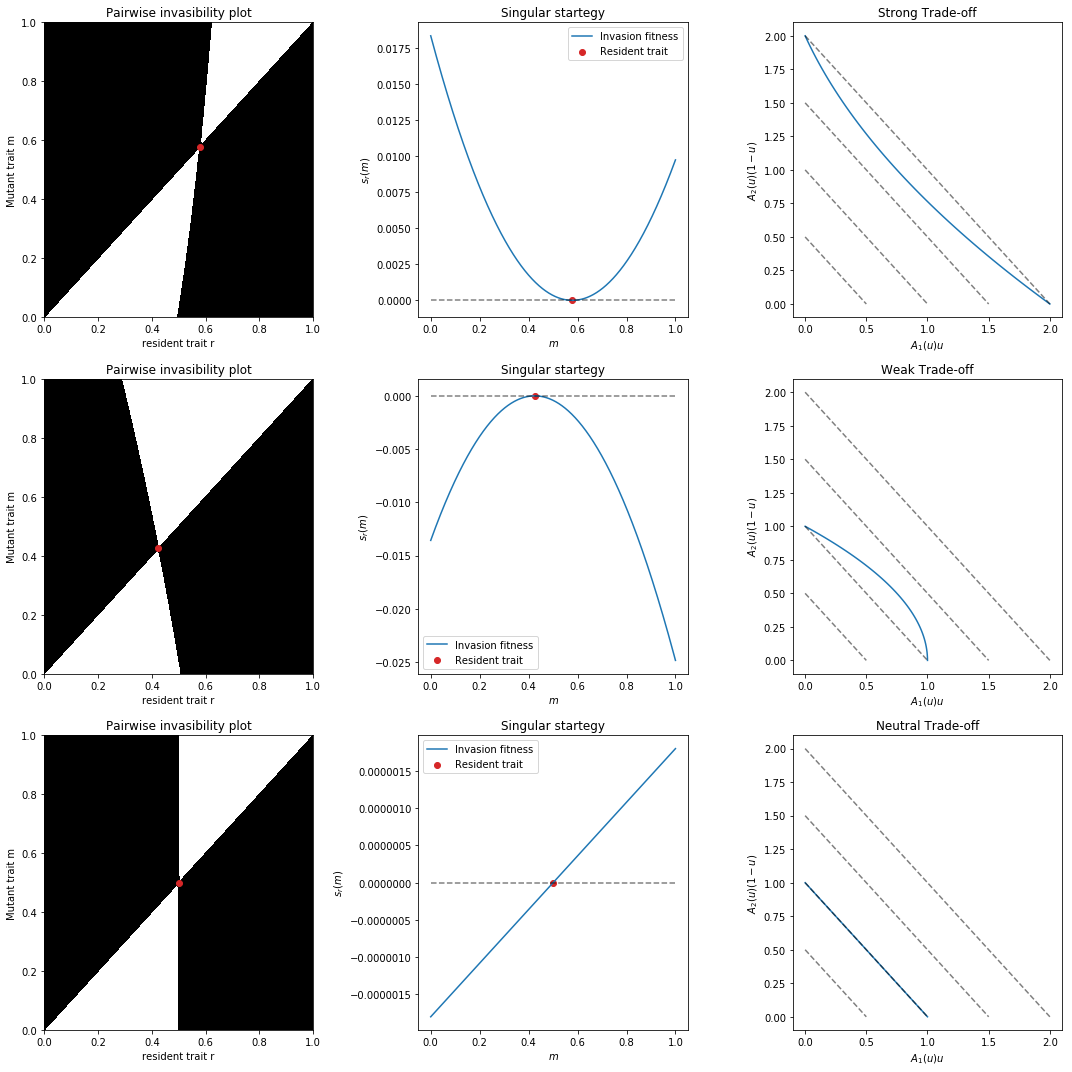

In [22]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i,(name,p) in enumerate((['Strong',p_strong],['Weak',p_weak],['Neutral',p_neutral])):
    R, M, pip = compute_pip(100,**p)
    display_pip(pip, R, M, ax[i,0])
    rstar = find_singular_trait_value(p)
    plot_local_landscape(ax[i,1],rstar)
    ax[i,0].scatter(rstar,rstar,color='C3')
    plot_tradeoff(ax[i,2],**p)
    ax[i,2].set(title="{} Trade-off".format(name))
plt.tight_layout()
plt.show()

The stability of this equilibrium depend on the nature of the tradeoff
between the two environments. We distinguish 3 cases inspired by the
work of Levin (Levin 1962, Rueffler 2004):

- **Neutral** if the tradeoff is linear (the search rate only depend on the time
    spent in each environment).

- **Strong** if the tradeoff is convex (i.e. mixed strategies fair worse than
    pure strategies) Then **\*Selection is disruptive,\*** we may
    observe an Evolutionary Branching Point.

- **Weak** if the tradeoff is concave (i.e. mixed strategies fair better than
    pure strategies). Then selection **\*Selection is stabilizing,\***
    the population will stay monomorphic.

# Exploring the branching 

The case `p_strong` leads to a singular point which is convergence stable but not evolutionary stable. We predict that this might cause a branching in the population. 

Remember how the PIP is interested in how a rare mutant can invade a
resident population ? We considered that if the rare mutant per capita
growth rate was positive ($s_r(m)$), the mutant would invade. We
completely disregard the rest of the invasion dynamics.

There is something easy we can look at though: the end of the invasion
dynamics. If a mutant somehow managed to be in high enough proportion so
that it is the one at equilibrium, and the resident is in rare
proportion, is the mutant able to drive the resident to extinction ?

The answer of course is to look at $s_m(r)$. This can be done by just
flipping the PIP along the diagonal (red in the figure).

Now if we superimpose the PIP with its flipped version, we get 3 kinds
of zone:

-   The mutant increases if rare, the resident decreases if rare (blue).
-   The mutant decreases if rare, the resident increases if rare (red).
-   Both mutant and resident increase if rare (green).

This last situation is called a **protected polymorphism**. In this
region we predict that the mutant can invade but not exclude the
resident leading to a dimorphic population.

One may add the isoclines zero of the polymorphic invasion fitness (cf.
main lecture) to find the final position of the branches.

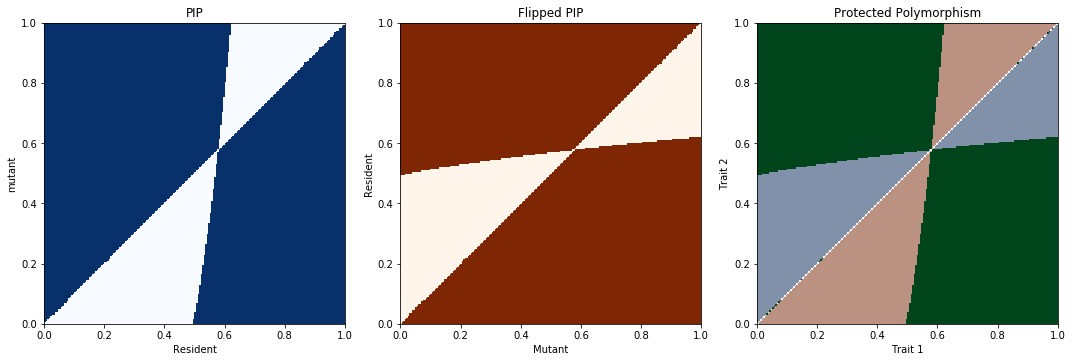

In [16]:
r, m, pip = compute_pip(200,**p_strong)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(pip>0, cmap='Blues', 
              origin='bottom', 
              interpolation='none',
              extent=[0,1,0,1])

ax[1].imshow(np.transpose(pip)>0, cmap='Oranges', 
              origin='bottom', 
              interpolation='none',
              extent=[0,1,0,1])

ax[2].imshow(pip>0, cmap='Blues', 
              origin='bottom', 
              interpolation='none',
              extent=[0,1,0,1])
ax[2].imshow(np.transpose(pip)>0, cmap='Oranges', 
              origin='bottom', 
              interpolation='none',
              extent=[0,1,0,1],alpha=0.5)

tep = np.logical_and(np.transpose(pip)>0,pip>0)
tep = np.ma.masked_where(tep == 0, tep)
tep[0,0]=0
ax[2].imshow(tep, cmap='Greens',
             origin='bottom', 
             interpolation='none',
             extent=[0,1,0,1])
ax[0].set(title='PIP',xlabel='Resident',ylabel='mutant')
ax[1].set(title='Flipped PIP',xlabel='Mutant',ylabel='Resident')
ax[2].set(title='Protected Polymorphism',xlabel='Trait 1',ylabel='Trait 2')
plt.tight_layout()
plt.show()

See the [second tutorial !](./dyad02_student.html)